In [1]:
#Import all the required packages
import os
import datetime
import click
import matplotlib

import random as rn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy import stats
from math import pi

from metrics import metrics
from quantileNetwork import QuantileNet, makeDataset, callNet

In [2]:
outputModelName = "quantCorrectionNetworkLong" #Network name
sampleNum=1 #Number of samples to make
numberOfJets = 10000 #Number of jets to consider for plotting
ptMin=100 #Minimum pt when using a delta
ptMax=120 #Maximum pt when using a delta

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["PYTHONHASHSEED"] = "0"
np.random.seed(42)
rn.seed(12345)
tf.random.set_seed(3)

#Load data
xValsPt = np.load("predicted1.npy")[:,:,0].reshape((-1))
xValsEta = np.load("predicted1.npy")[:,:,1].reshape((-1))
xValsPhi = np.load("predicted1.npy")[:,:,2].reshape((-1))
xValsE = np.load("predicted1.npy")[:,:,3].reshape((-1))

xVals = np.concatenate([[xValsPt], [xValsEta], [xValsPhi], [xValsE]], axis=0).T

yValsPt = np.load("finalJets.npy")[:-1,0].repeat(100,axis=0)
yValsPt = np.load("finalJets.npy")[:-1,0].repeat(100,axis=0)
yValsPt=np.log(np.where(yValsPt<0.01, 0.01, yValsPt))
yValsEta = np.load("finalJets.npy")[:-1,1].repeat(100,axis=0)
yValsPhi = np.load("finalJets.npy")[:-1,2].repeat(100,axis=0)
yValsE = np.load("finalJets.npy")[:-1,3].repeat(100,axis=0)
yValsE=np.log(np.where(yValsE<1, 1, yValsE))
yVals = np.concatenate([[yValsPt], [yValsEta], [yValsPhi], [yValsE]], axis=0).T

yValsPt = np.load("rawJets.npy")[:-1,0].repeat(100,axis=0)
yValsEta = np.load("rawJets.npy")[:-1,1].repeat(100,axis=0)
yValsPhi = np.load("rawJets.npy")[:-1,2].repeat(100,axis=0)
yValsE = np.load("rawJets.npy")[:-1,3].repeat(100,axis=0)
rawRecoJets = np.concatenate([[yValsPt], [yValsEta], [yValsPhi], [yValsE]], axis=0).T

yValsPt = np.load("initialJets.npy")[:-1,0].repeat(100,axis=0)
yValsEta = np.load("initialJets.npy")[:-1,1].repeat(100,axis=0)
yValsPhi = np.load("initialJets.npy")[:-1,2].repeat(100,axis=0)
yValsE = np.load("initialJets.npy")[:-1,3].repeat(100,axis=0)
recoJets = np.concatenate([[yValsPt], [yValsEta], [yValsPhi], [yValsE]], axis=0).T

#Make datasets
_, rawRecoJets, _, _ = train_test_split(rawRecoJets,
                                                        rawRecoJets,
                                                        test_size=89/100,
                                                        random_state=42)

_, recoJets, _, _ = train_test_split(recoJets,
                                                        recoJets,
                                                        test_size=89/100,
                                                        random_state=42)



trainIn, inputData, trainOut, outputData = train_test_split(xVals,
                                                        yVals,
                                                        test_size=89/100,
                                                        random_state=42)

#Get normalization information
normInfoIn=np.zeros((4,2))
normInfoOut=np.zeros((4,2))

trainIn = trainIn.T
trainOut = trainOut.T
inputData = inputData.T

for x in range(4):
    normInfoIn[x,0] = np.mean(trainIn[x])
    normInfoIn[x,1] = np.std(trainIn[x])
    normInfoOut[x,0] = np.mean(trainOut[x])
    normInfoOut[x,1] = np.std(trainOut[x])
    inputData[x,:] = (inputData[x,:]-normInfoIn[x,0])/normInfoIn[x,1]
inputData = inputData.T



(21246500, 4)
(21246500, 4)


In [3]:
model = QuantileNet() #Used to load network

#Load model
newModel = tf.keras.models.load_model(outputModelName, custom_objects={"QuantileNet": QuantileNet, "loss": model.loss})
inputDataSmall = []#inputData[:counts]
outputDataSmall=[]
rawSmall=[]
recoSmall=[]


#Select data
for x in range(numberOfJets):
    #Algorithm output delta
    #if(np.exp(inputData[x,0]*normInfoIn[0,1]+normInfoIn[0,0])<ptMax and np.exp(inputData[x,0]*normInfoIn[0,1]+normInfoIn[0,0])>ptMin and len(rawSmall)<100000):
    
    #Gen delta
    #if(np.exp(outputData[x,0])<ptMax and np.exp(outputData[x,0])>ptMin and len(rawSmall)<100000):
    
    #Raw Reco Delta
    #if(rawRecoJets[x,0]<ptMax and rawRecoJets[x,0]>ptMin and len(rawSmall)<100000):
    
    #All
    if(True):
        inputDataSmall.append(inputData[x,:])
        outputDataSmall.append(outputData[x,:])
        rawSmall.append(rawRecoJets[x,:])
        recoSmall.append(recoJets[x,:])
rawSmall = np.array(rawSmall)
recoSmall = np.array(recoSmall)
inputDataSmall = np.array(inputDataSmall)
outputDataSmall = np.array(outputDataSmall)
counts=len(outputDataSmall)


In [4]:
#Call the network
out=callNet(newModel, #Network
            sampleNum, #Number of samples
            tf.cast(tf.transpose(inputDataSmall), tf.float32), #Input
            inputDataSmall.shape[0], #Number of examples (batch size)
            inputDataSmall.shape[1], #4d input
            4) #4d output

10000 tf.Tensor(
[[ 1.0031941 ]
 [ 0.3233698 ]
 [-0.07268288]
 [ 0.44247103]
 [ 1.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.        ]
 [-0.        ]
 [ 0.        ]
 [-2.701732  ]], shape=(12, 1), dtype=float32)
finalInput (10000, 12)


In [5]:
#Extract predictions
output=np.array(out)

ptPredicted=np.exp(np.reshape(output[:,:,0]*normInfoOut[0,1]+normInfoOut[0,0],-1))
etaPredicted=np.reshape(output[:,:,1]*normInfoOut[1,1]+normInfoOut[1,0],-1)
phiPred=np.reshape(output[:,:,2]*normInfoOut[2,1]+normInfoOut[2,0],-1)
ePred=np.exp(np.reshape(output[:,:,3]*normInfoOut[3,1]+normInfoOut[3,0],-1))

inputDataSmall[:,0] = np.exp((inputDataSmall[:,0]*normInfoIn[0,1]+normInfoIn[0,0]))
inputDataSmall[:,1] = (inputDataSmall[:,1]*normInfoIn[1,1]+normInfoIn[1,0])
inputDataSmall[:,2] = (inputDataSmall[:,2]*normInfoIn[2,1]+normInfoIn[2,0])
inputDataSmall[:,3] = np.exp((inputDataSmall[:,3]*normInfoIn[3,1]+normInfoIn[3,0]))

ptGen=np.exp(outputDataSmall[:,0])
etaGen=outputDataSmall[:,1]
phiGen=outputDataSmall[:,2]
eGen=np.exp(outputDataSmall[:,3])

mSquared = ePred**2- ptPredicted**2/(1-np.tanh(etaPredicted)**2)
mSquaredAlg = inputDataSmall[:,3]**2- inputDataSmall[:,0]**2/(1-np.tanh(inputDataSmall[:,1])**2)
mSquaredTrue = eGen**2- ptGen**2/(1-np.tanh(etaGen)**2)
mSquaredReco = recoSmall[:,3]**2- recoSmall[:,0]**2/(1-np.tanh(recoSmall[:,1])**2)
mSquaredRawReco = rawSmall[:,3]**2- rawSmall[:,0]**2/(1-np.tanh(rawSmall[:,1])**2)


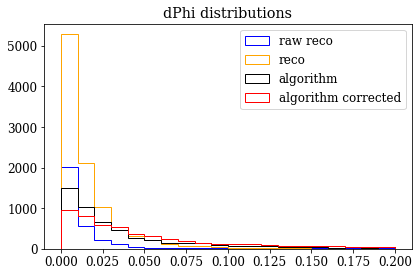

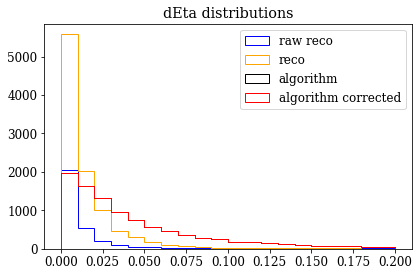

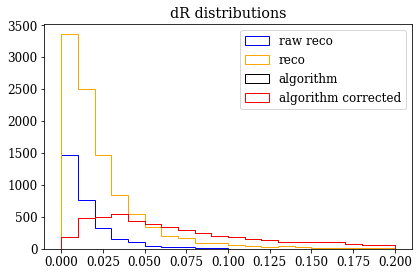

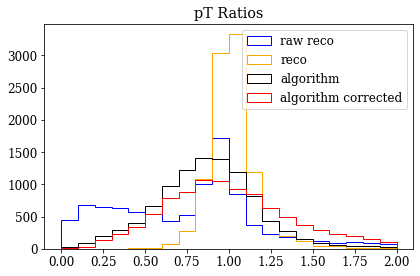

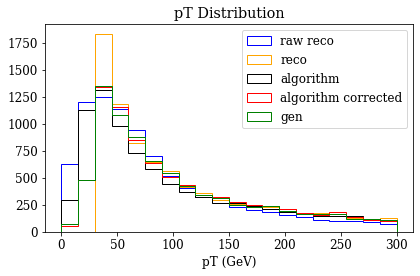

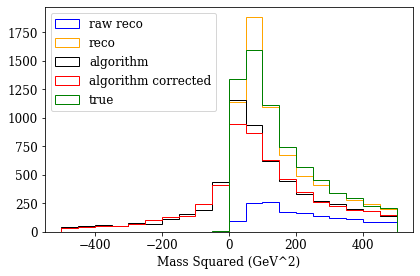

In [12]:
font = {'family' : 'serif',
        'size'   : 12}
matplotlib.rc('font', **font)

dPhi2Pred = np.minimum(np.square(np.repeat(phiGen,sampleNum)-phiPred), np.square(phiPred-(np.repeat(phiGen,sampleNum))))
dPhi2Alg = np.minimum(np.square(phiGen-inputDataSmall[:,2]), np.square(inputDataSmall[:,2]-phiGen))
dPhi2Reco = np.minimum(np.square(phiGen-recoSmall[:,2]), np.square(recoSmall[:,2]-phiGen))
dPhi2Raw = np.minimum(np.square(phiGen-rawSmall[:,2]), np.square(rawSmall[:,2]-phiGen))


dEta2Pred = np.square(np.repeat(etaGen,sampleNum)-etaPredicted)
dEta2Alg = np.square(etaGen-inputDataSmall[:,1])
dEta2Reco = np.square(etaGen-recoSmall[:,1])
dEta2Raw = np.square(etaGen-rawSmall[:,1])

dRPred = np.sqrt(dEta2Pred+dPhi2Pred)
dRAlg = np.sqrt(dEta2Alg+dPhi2Alg)
dRReco = np.sqrt(dEta2Reco+dPhi2Reco)
dRRaw = np.sqrt(dEta2Raw+dPhi2Raw)


ptRatioPred = np.abs(ptPredicted)/np.repeat(ptGen, sampleNum)
ptRatioAlg = np.abs(inputDataSmall[:,0])/ptGen
ptRatioReco = np.abs(recoSmall[:,0])/ptGen
ptRatioRaw = np.abs(rawSmall[:,0])/ptGen

#Make some plots

bins=20
plt.figure(figsize=(6,4))
plt.hist(np.sqrt(dPhi2Raw), range=(0,0.2), bins=bins, label="raw reco", histtype="step", color="b")
plt.hist(np.sqrt(dPhi2Reco), range=(0,0.2), bins=bins, label="reco", histtype="step", color="orange")
plt.hist(np.sqrt(dPhi2Alg), range=(0,0.2), bins=bins, label="algorithm", histtype="step", color="k", weights=np.ones(dEta2Pred.shape)/sampleNum)
plt.hist(np.sqrt(dPhi2Pred), range=(0,0.2), bins=bins, label="algorithm corrected", histtype="step", color="r", weights=np.ones(dEta2Pred.shape)/sampleNum)
plt.legend()
plt.title("dPhi distributions")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(np.sqrt(dEta2Raw), range=(0,0.2), bins=bins, label="raw reco", histtype="step", color="b")
plt.hist(np.sqrt(dEta2Reco), range=(0,0.2), bins=bins, label="reco", histtype="step", color="orange")
plt.hist(np.sqrt(dEta2Pred), range=(0,0.2), bins=bins, label="algorithm", histtype="step", color="k", weights=np.ones(dEta2Pred.shape)/sampleNum)
plt.hist(np.sqrt(dEta2Pred), range=(0,0.2), bins=bins, label="algorithm corrected", histtype="step", color="r", weights=np.ones(dEta2Pred.shape)/sampleNum)
plt.legend()
plt.title("dEta distributions")
plt.tight_layout()
plt.show()


plt.figure()
plt.hist(dRRaw, range=(0,0.2), bins=bins, label="raw reco", histtype="step", color="b")
plt.hist(dRReco, range=(0,0.2), bins=bins, label="reco", histtype="step", color="orange")
plt.hist(dRPred, range=(0,0.2), bins=bins, label="algorithm", histtype="step", color="k", weights=np.ones(dEta2Pred.shape)/sampleNum)
plt.hist(dRPred, range=(0,0.2), bins=bins, label="algorithm corrected", histtype="step", color="r", weights=np.ones(dEta2Pred.shape)/sampleNum)
plt.legend()
plt.title("dR distributions")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(ptRatioRaw, range=(0,2), bins=bins, label="raw reco", histtype="step", color="b")
plt.hist(ptRatioReco, range=(0,2), bins=bins, label="reco", histtype="step", color="orange")
plt.hist(ptRatioAlg, range=(0,2), bins=bins, label="algorithm", histtype="step", color="k", weights=np.ones(dEta2Pred.shape)/sampleNum)
plt.hist(ptRatioPred, range=(0,2), bins=bins, label="algorithm corrected", histtype="step", color="r", weights=np.ones(dEta2Pred.shape)/sampleNum)
plt.legend()
plt.title("pT Ratios")
plt.tight_layout()
plt.show()


plt.figure()
plt.hist(rawSmall[:,0], range=(0,300), bins=bins, label="raw reco", histtype="step", color="b")
plt.hist(recoSmall[:,0], range=(0,300), bins=bins, label="reco", histtype="step", color="orange")
plt.hist(inputDataSmall[:,0], range=(0,300), bins=bins, label="algorithm", histtype="step", color="k")
plt.hist(ptPredicted, range=(0,300), bins=bins, label="algorithm corrected", histtype="step", weights=np.ones(dEta2Pred.shape)/sampleNum, color="r")
plt.hist(ptGen, range=(0,300), bins=bins, label="gen", histtype="step", color="g")
plt.xlabel("pT (GeV)")
plt.legend()
plt.title("pT Distribution")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(np.reshape(mSquaredRawReco,-1), bins=bins, label="raw reco", histtype="step", range=(-500,500), color="b")
plt.hist(np.reshape(mSquaredReco,-1), bins=bins, label="reco", histtype="step",  range=(-500,500), color="orange")
plt.hist(np.reshape(mSquaredAlg,-1), bins=bins, label="algorithm", histtype="step",  range=(-500,500), color="k")
plt.hist(np.reshape(mSquared,-1), bins=bins, label="algorithm corrected", histtype="step", range=(-500,500), color="r")
plt.hist(mSquaredTrue, bins=bins,label="true", histtype="step", range=(-500,500), color="g")
plt.xlabel("Mass Squared (GeV^2)")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
m=len(np.reshape(ptPredicted,-1))#/sampleNum
n=len(ptGen)
print(m,n)
en = m * n / (m + n)
stat, p = stats.ks_2samp(np.reshape(ptPredicted,-1),ptGen)
p = stats.kstwo.sf(stat, np.round(en))
print("pt same prob", p)
stat, p = stats.ks_2samp(np.reshape(etaPredicted,-1),etaGen)
p = stats.kstwo.sf(stat, np.round(en))
print("eta same prob", p)
stat, p = stats.ks_2samp(np.reshape(phiPred,-1),phiGen)
p = stats.kstwo.sf(stat, np.round(en))

print("phi same prob", p)
stat, p = stats.ks_2samp(np.reshape(ePred,-1),eGen)
p = stats.kstwo.sf(stat, np.round(en))
print("e same prob", p)


10000 10000
pt same prob 0.707275967636168
eta same prob 0.9999912550260008
phi same prob 0.24152197461147928
e same prob 0.8197954216248635
